# Library imports

In [0]:
#Basic imports
import pandas as pd
import numpy as np

#Scipy imports
from scipy.stats import skew, mode

#Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

#SkLearn general imports
from sklearn.model_selection import train_test_split, cross_val_score, \
GridSearchCV

#Keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


# Data aquisition

For simplicity, both datasets a loaded now so we can easily apply any transformations to the entire dataset.

In [0]:
train_df = pd.read_csv('train.csv', index_col = 0)
test_df = pd.read_csv('test.csv', index_col = 0)

# Data analysis

The exploratory data analysis will only be conducted on the train data since we do not want data intended for test/ production to affect how we perceive the problema at hand.

## Missing values

Before we proceed to the actual  exploratory data analysis, it is important to find, evaluate and handle the missing values. In this step, both train and test data will be handled. Still, a different approach is taken for each dataset.

The first step is to define a class which will be used not only to handle missing values, but also to perform feature engineering.

In [0]:
class Transform:
  
  def __init__(self, train_data, test_data):
    self.train_data = train_data.copy()
    self.test_data = test_data.copy()
    self.data = self.train_data.append(self.test_data, sort = False)
    
  #One hot encode entire dataset function
  def one_encoder(self, data, cols):
      for c in cols:
        dummy = pd.get_dummies(data[c])
        dummy = dummy.drop(columns = dummy.columns.values[0])
        data[dummy.columns.values] = dummy
        data = data.drop(columns = c)
      return data
        
  #Remove attributes from entire dataset function
  def remove_atr(self, cols):
    self.train_data = self.train_data.drop(columns = cols)
    self.test_data = self.test_data.drop(columns = cols)
    
  #Transform attribute to binary function
  def binary_transform(self, col, yes_value, no_value):
    self.train_data[col] = np.where(self.train_data[col] != yes_value, no_value, 
                                    yes_value)
    self.test_data[col] = np.where(self.test_data[col] != yes_value, no_value, 
                                    yes_value)
  
  #Fill train data missing values function
  def fillna_train(self, col, ctype, new_val):
    if ctype == 'to_value':
      pass
    elif ctype == 'most_common':
      new_val = mode(self.train_data[col].values)[0][0]
    elif ctype == 'mean':
      new_val = np.nanmean(self.train_data[col].values)
    else:
      print('Invalid "ctype" argument value!')
      return 1
    self.train_data[col] = self.train_data[col].fillna(value = new_val) 
  
  #Fill test data missing values function
  def fillna_test(self, col, ctype, new_val):
    if ctype == 'to_value':
      pass
    elif ctype == 'most_common':
      new_val = mode(self.train_data[col].values)[0][0]
    elif ctype == 'mean':
      new_val = np.nanmean(self.train_data[col].values)
    else:
      print('Invalid "ctype" argument value!')
      return 1
    self.test_data[col] = self.test_data[col].fillna(value = new_val) 

In [0]:
#Define class instance
df = Transform(train_df, test_df)

### Train data missing values

First, we have to find the missing values in the training data.

In [0]:
#Find train data missing values
is_null = df.train_data.isnull().sum()
is_null = is_null[is_null > 0]
print(is_null)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


For some attributes, the missing data actually represents a valid categorical value.

From the data description file (found [here](https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/205873/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1563642550&Signature=HuaV551Ss3xOzw9Dm2CrqvkPVeXcMhZBnEz3WqCIGnq4RKgr%2FLl4WoRyw%2B4cwlhKKsoudaMVO3QpM5Zjb4SEljQhMmrDLqCd4e3FNY8gKiaqhngp9499ymwGZWC92TzUJPJYiJuBAKMcO%2FEF7ZcKOAy8OPrRJ6USqakiVqoWn3UJIWqRAQ2t1qPcTOO7mBctvnPr33HkLajgA6zSAVLi6egVN34P6MH7gEhGf3hYyjl%2BbdnOT56sedvzGU7%2BAlFk1hyCyJ4QmqBdjErhTRQhEAfWaH5XLnINuZFQ6mKWUN3%2FKdJC6mpqBANbgN0DY06MUZtxlFiTuzvhYTbRpABW5A%3D%3D)), we can identify such attributes 

In [0]:
#Replace missing values for categorical value 'None'
nan_to_category = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 
                   'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                   'GarageCond','PoolQC', 'Fence', 'MiscFeature', 
                   'BsmtExposure', 'BsmtFinType2', 'MasVnrType']

df.fillna_train(nan_to_category, 'to_value', 'None')

The remaining missing values are handled more specifically.

In [0]:
#Replace 'Electrical' missing value with most common categorical value
df.fillna_train('Electrical', 'most_common', 0)

#Replace 'MasVnrArea' missing values with '0'
df.fillna_train('MasVnrArea', 'to_value', 0)

#Replace 'GarageYrBlt' missing values with mean value
df.fillna_train('GarageYrBlt', 'mean', 0)

#Remove 'LotFrontage' attribute (from entire dataset)
df.remove_atr('LotFrontage')

### Test data missing values

In [0]:
#Find test data missing values
is_null = df.test_data.isnull().sum()
is_null = is_null[is_null > 0]
print(is_null)

MSZoning           4
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


The test data missing values will be filled based on the training data values. 

For example, the missing values for a given categorical attribute will be filled with the most common value in the train dataset.

In [0]:
#Replace for categorical value
df.fillna_test(nan_to_category, 'to_value', 'None')

#Replace for '0'
to_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
           'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 
           'GarageArea']
df.fillna_test(to_zero, 'to_value', 0)

#Replace for most common value
to_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual',
           'Functional', 'SaleType']
for col in to_mode:
  df.fillna_test(col, 'most_common', 0)
  
#Replace for mean value
df.fillna_test('GarageYrBlt', 'mean', 0)

## Preliminary data exploration

Initially, we plot the distribution for some categorical attributes.

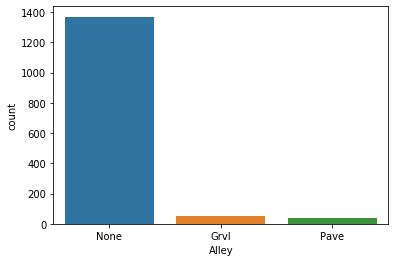

In [0]:
#Alley
plt.figure()
sns.countplot(df.train_data['Alley'])

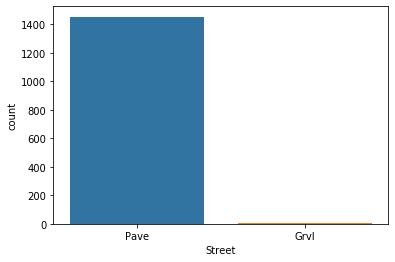

In [0]:
#Street
plt.figure()
sns.countplot(df.train_data['Street'])

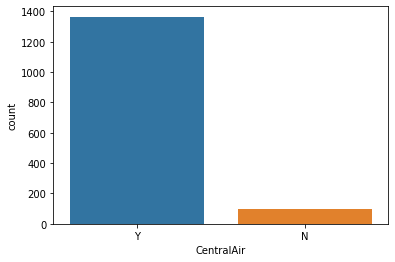

In [0]:
#CentrailAir
plt.figure()
sns.countplot(df.train_data['CentralAir'])

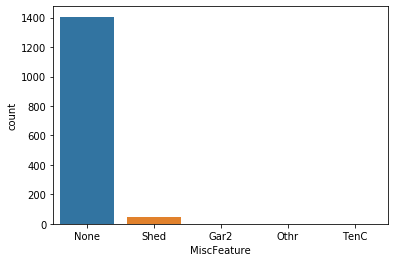

In [0]:
#MiscFeature
plt.figure()
sns.countplot(df.train_data['MiscFeature'])

These plots show some categorical attributes present poor distribution. In this form, they offer little to no help for a regression model. Some action must be taken regarding this issue. This is discussed in more detail in the 'Data transformation' section.

Now, we plot some numerical attributes histrograms.


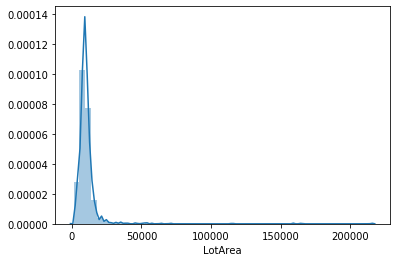

In [0]:
#LotArea
plt.figure()
sns.distplot(df.train_data['LotArea'])

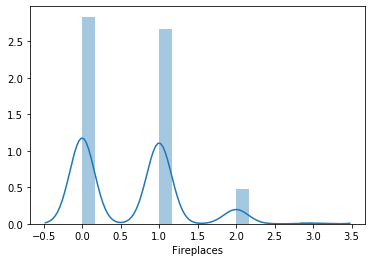

In [0]:
#Fireplaces
plt.figure()
sns.distplot(df.train_data['Fireplaces'])

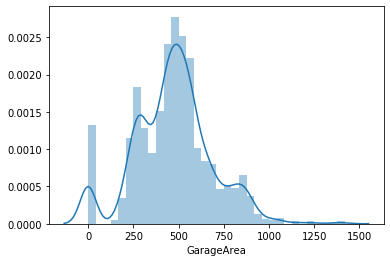

In [0]:
#GarageArea
plt.figure()
sns.distplot(df.train_data['GarageArea'])

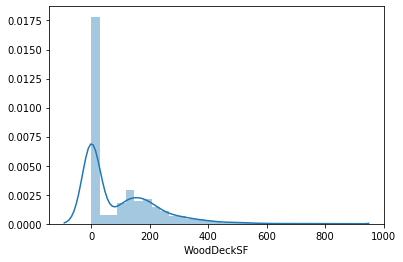

In [0]:
#WoodDeckSF
plt.figure()
sns.distplot(df.train_data['WoodDeckSF'])

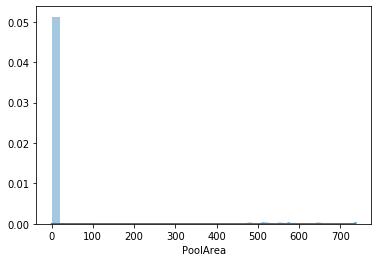

In [0]:
#PoolArea
plt.figure()
sns.distplot(df.train_data['PoolArea'])

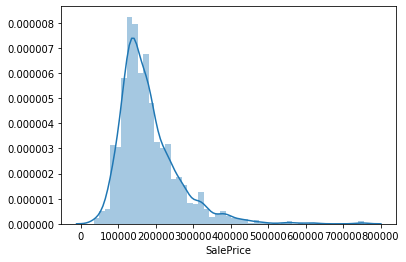

In [0]:
#SalePrice
plt.figure()
sns.distplot(df.train_data['SalePrice'])

The numerical plots show some attributes present very skewed distribution. This also requires some further analysis to define the best course of action in each case. More on 'Data transformation'.

## Investigating numerical attributes

First, we investigate how some numerical attributes relate to the target value.

These attributes were chosen based on subjective perception of their importance to 'SalePrice'.

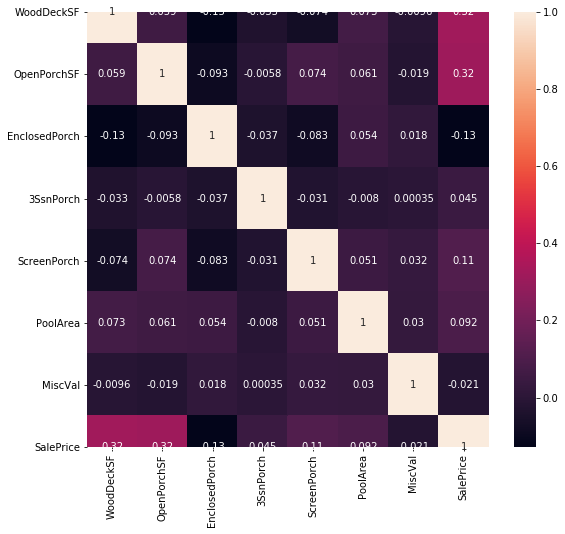

In [0]:
#Select attributes to investigate
inv_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
            'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

plt.figure(figsize = (9,8))
sns.heatmap(data = df.train_data[inv_cols].corr(), annot = True)

At this stage, we are only going to make decisions regarding attributes
with really poor behavior in our analysis.

For instance, given the correlation map above, only the following attributes will be selected for removal:

* 'MiscVal'
* '3SsnPorch'
* 'PoolArea'

obs: These attributes will not be removed now, for they may be used later on the 'Data transformation' section.

In [0]:
to_remove = ['MiscVal', '3SsnPorch', 'PoolArea']

The next step is to evalute skewness to the numerical attributes.

In [0]:
num_atr = df.train_data.select_dtypes(exclude = ['object']).columns.values
skew_atr = np.abs(pd.Series(data = skew(df.train_data[num_atr].copy()), 
                            index = num_atr))
skew_atr.sort_values(ascending = False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
SalePrice         1.880941
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
GarageYrBlt       0.667488
Fireplaces        0.648898
YearBuilt         0.612831
BsmtFullBath      0.595454
YearRemodAdd      0.503044
GarageCars        0.342197
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
dtype: float64

From the values above, we select the most skewed attributes.

In [0]:
#Select most skewed attributes
most_skew = [x for x in skew_atr.index if skew_atr[x] > np.mean(skew_atr)]
most_skew

['LotArea',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

We then investigate their relationship to 'SalePrice' in their current form.

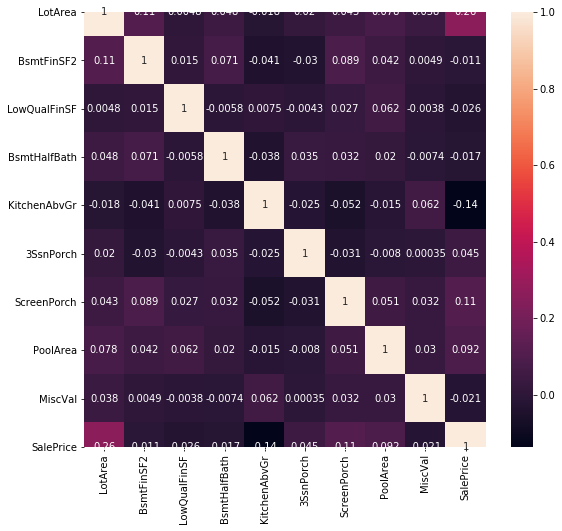

In [0]:
#Plot heatmap for skewed attributes
plot_skew_cols = most_skew + ['SalePrice']

plt.figure(figsize = (9,8))
sns.heatmap(data = df.train_data[plot_skew_cols].corr(), annot = True)

As expected, most of the skewed attributes have poor 'SalePrice' correlations.

We now apply a transformation in order to verify whether it affects its relationship to the target value.

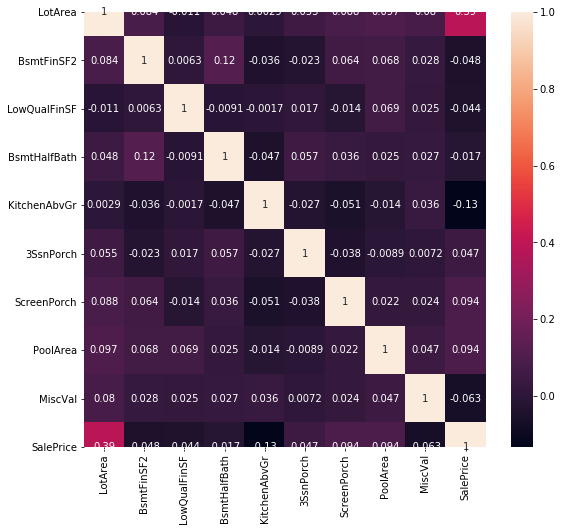

In [0]:
#Apply log(value + 1) transformation to skewed data
skewed_df = np.log(df.train_data[most_skew].copy() + 1)
skewed_df['SalePrice'] = df.train_data['SalePrice'].values

plt.figure(figsize = (9,8))
sns.heatmap(data = skewed_df.corr(), annot = True)

The comparison between the two heatmaps shows the transformation has a positive effect on the following attributes:

* 'LotArea'
* 'BsmtFinSF2'
* 'LowQualFinSF'
* 'MiscVal'

This results sugests the above listed attributes should be transformed for the regression model training. The remaining attributes show no correlation improvement, therefore should not be transformed.

An important final observation is the attributes to be transformed are not necessarily well correlated to 'SalePrice' and are still required to go trough more analysis before they are selected to the regression model. This evaluation cocerns only the attributes skewness handling.

In [0]:
to_transform = ['LotArea', 'BsmtFinSF2', 'LowQualFinSF', 'MiscVal']

## Investigate categorical attributes

In [0]:
#Select categorical attributes
cat_atr = df.train_data.select_dtypes(include = ['object']).columns.values
print(cat_atr)

As shown previously, some of the categorical attributes present very poor distribution. This can seriously affect how much a feature is able to contribute to the machine learning algorithm.

To properly identify the most poorly distributed attributes we compute the importance of the most common value for each categorical feature.

In [0]:
#Compute percentage of attributes data corresponding to its most common value
pct = []
for col in cat_atr:
  pct.append(df.train_data[col].value_counts()[0] / df.train_data.shape[0])

atr_dist = pd.Series(data = pct, index = cat_atr).sort_values(ascending = False)
print(atr_dist)

We then select those attributes with the worst distributions and plot them so that we can have a better idea of how they behave.

In [0]:
dist_limit = 0.9
worst_dist = [x for x in atr_dist.index if atr_dist[x] >= dist_limit]

for col in worst_dist:
  plt.figure()
  sns.countplot(df.train_data[col])

From the plots shown above, it becomes clear some features have little to offer in a regression model. The best course of action is to remove them. They are:

* 'Utilities'
* 'Street'
* 'PoolQC'
* 'Condition2'
* 'RoofMatl'
* 'Heating'

As for the other attributes, some more in depth analysis will be conducted to have a better idea of how well they can help the predictive model.

In [0]:
to_remove += ['Utilities', 'Street', 'PoolQC', 'Condition2', 'RoofMatl', 
              'Heating']

# Data transformation

The data analysis has shown us the various attributes require different approaches in order to extract the maximum amount of useful information for the regression model.

Right now, our goal is to:

1.   Identify whether or not each feature requires transformation;
2.   Choose the ideal transformation to each feature.


## Preliminary attribute selection

We have already selected a few attributes to be removed. Before any of the actual data transformation takes place, let's remove these features from our dataset.

In [0]:
#Remove selected attributes
df.remove_atr(to_remove)

## Numerical attributes

In [0]:
#Reselect numerical attributes
num_atr = df.train_data.select_dtypes(exclude = ['object']).columns.values
print(num_atr)

['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'GarageCars'
 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' 'ScreenPorch'
 'MoSold' 'YrSold' 'SalePrice']


The only transformation to be done for the numerical attributes is the skewness treatment.

In [0]:
to_transform = [x for x in to_transform if x not in to_remove]
print(to_transform)

['LotArea', 'BsmtFinSF2', 'LowQualFinSF']


In [0]:
for col in to_transform:
  df.train_data[col] = np.log(df.train_data[col] + 1)
  df.test_data[col] = np.log(df.test_data[col] + 1)

## Categorical attributes

The categorical attributes can be split into two groups based on the nature of their values:

1. Ordinal categoric values
2. Non-ordinal categoric values 

The main difference between these two groups is the second one requires a OneHotEnconding treatment, while the first group doest not requires a specific type of encoding. Given the data description [file](https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/205873/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1563642550&Signature=HuaV551Ss3xOzw9Dm2CrqvkPVeXcMhZBnEz3WqCIGnq4RKgr%2FLl4WoRyw%2B4cwlhKKsoudaMVO3QpM5Zjb4SEljQhMmrDLqCd4e3FNY8gKiaqhngp9499ymwGZWC92TzUJPJYiJuBAKMcO%2FEF7ZcKOAy8OPrRJ6USqakiVqoWn3UJIWqRAQ2t1qPcTOO7mBctvnPr33HkLajgA6zSAVLi6egVN34P6MH7gEhGf3hYyjl%2BbdnOT56sedvzGU7%2BAlFk1hyCyJ4QmqBdjErhTRQhEAfWaH5XLnINuZFQ6mKWUN3%2FKdJC6mpqBANbgN0DY06MUZtxlFiTuzvhYTbRpABW5A%3D%3D), we can easily identify which attributes belong to each group.

In [0]:
#Reselect categorical attributes
cat_atr = df.train_data.select_dtypes(include = ['object']).columns.values
print(cat_atr)

['MSZoning' 'Alley' 'LotShape' 'LandContour' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'BldgType' 'HouseStyle' 'RoofStyle'
 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinType2' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


In [0]:
#Ordinal categorical attributes
ord_cat_atr = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
              'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
              'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
              'Fence']

#Non-ordinal categorical attributes
nord_cat_atr = [x for x in cat_atr if x not in ord_cat_atr]


First, we encode the ordinal categorical attributes.

In [0]:
#Create encoding dictionary
encoder_dict = {'LotShape': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3},
               'LandSlope': {'Gtl': 0, 'Mod': 1, 'Sev': 2},
               'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
               'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
               'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
               'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
               'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0},
               'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
               'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
               'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
               'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
               'Functional': {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0},
               'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
               'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0},
               'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
               'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0},
               'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},
               'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}}

In [0]:
#Encode attributes
df.train_data.replace(encoder_dict, inplace = True)
df.test_data.replace(encoder_dict, inplace = True)

Now, the one-hot enconding is performed for the entire dataset at once.

In [0]:
#Apply OneHotEncoding to attributes
dataset = df.train_data.append(df.test_data, sort = False)
dataset = df.one_encoder(dataset, nord_cat_atr)

# Regression model

For the regression model, we are going to apply a Multilayer Perceptron network using the Keras library.

The first step is then to define the neural network as a function.

In [0]:
def mlp_regression(n_in, n_out, n_nodes, n_layers, act, loss_f, opt, drop):
  model = Sequential()
  model.add(Dense(units = n_nodes, activation = act, input_dim = n_in))
  model.add(Dropout(drop))
  for i in range(n_layers):
    model.add(Dense(units = n_nodes, activation = act))
    model.add(Dropout(drop))
  model.add(Dense(units = n_out, activation = 'linear'))
  
  model.compile(optimizer = opt, loss = loss_f, 
                metrics = ['mean_squared_error'])
  return model

We now split the treated data into train and test datasets once again:

In [0]:
train_dataset = dataset.iloc[:df.train_data.shape[0],:]
test_dataset = dataset.iloc[df.train_data.shape[0]:,:]

Finally, the train data is split between attributes and target:

In [0]:
target = train_dataset['SalePrice'].values
atr = train_dataset.drop(columns = 'SalePrice').values

## Tuning hyperparameters

In order to guarantee optimal performance, we first have to tune the regression model hyperparameters. To do that, we must write our model in the following form:

In [0]:
model = KerasRegressor(build_fn = mlp_regression)

The next step is to set the hyperparameters grid. 

In [0]:
param = {'n_in': [atr.shape[1]],
         'n_out': [1],
         'n_layers': [0, 1, 2, 4],
         'n_nodes': [30, 50, 80, 100],
         'opt': ['adam'],
         'act': ['relu'],
         'loss_f': ['mse'],
         'drop': [0.0, 0.2, 0.3],
         'batch_size': [10, 30, 50],
         'epochs': [1000]}

In [0]:
final_grid = GridSearchCV(estimator = model,
                     param_grid = param,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = 10,
                     verbose = 2)
final_grid.fit(atr, target)

In [0]:
#Save grid results
final_df = pd.DataFrame(data = final_grid.cv_results_)
final_df.to_csv('final_grid.csv')

C:\Users\raiss\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\raiss\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\raiss\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\raiss\Anaconda3\lib\site-packages\sklearn\util

### Test tuned model

In [0]:
#Test final model
best_p = final_grid.best_params_

final_model = KerasRegressor(build_fn = mlp_regression,                      
                            n_in = best_p['n_in'],
                            n_out = best_p['n_out'],
                            n_layers = best_p['n_layers'],
                            n_nodes = best_p['n_nodes'],
                            drop = best_p['drop'],
                            act = best_p['act'],
                            opt = best_p['opt'],
                            loss_f = best_p['loss_f'],
                            batch_size = best_p['batch_size'],
                            epochs = best_p['epochs'])

In [0]:
#Cross validate final model
score = cross_val_score(estimator = final_model,
                       X = atr,
                       y = target,
                       scoring = 'neg_mean_squared_log_error',
                       cv = 10,
                       n_jobs = 10,
                       verbose = 2)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
C:\Users\raiss\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 15.1min remaining: 35.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 16.6min finished


In [0]:
#Print final model result
print(np.abs(np.mean(score)))
print(np.std(score))

0.019444031971774762
0.007140995099924414


### Train model

Now we train our model using the entire training data set.

In [0]:
pred_model = mlp_regression(n_in = best_p['n_in'],
                            n_out = best_p['n_out'],
                            n_layers = best_p['n_layers'],
                            n_nodes = best_p['n_nodes'],
                            drop = best_p['drop'],
                            act = best_p['act'],
                            opt = best_p['opt'],
                            loss_f = best_p['loss_f'])

In [0]:
pred_model.fit(atr, target, 
                epochs = best_p['epochs'], 
                batch_size = best_p['batch_size']) 

### Predict values for test data set

Finally, we use the trained model to predict values for the test dataset and create the submission file.

In [0]:
#Predict values for test dataset
pred = pred_model.predict(test_dataset.drop(columns = 'SalePrice'))

In [0]:
#Write submission file
submission = pd.Series(data = np.ndarray.tolist(pred), index = test_df.index.values)
submission.to_csv('submission.csv')